In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import json
import glob
import keras
from datetime import timedelta
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import json
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


Example of importing functions from txt file

In [2]:
import my_practice_module

In [3]:
my_practice_module.hello_world()

Hello World


In [4]:
list_of_file_names = glob.glob("./zip_2/*.csv")

In [5]:
read_data_list_2 = []
fail_list = []
for i, data in enumerate(list_of_file_names):
    try:
        data = pd.read_csv(data)
        #data = unicode(data, errors='replace')
        read_data_list_2.append(data)
    except UnicodeDecodeError:
        fail_list.append(i)
#read_data_list
#fail_list
list_of_file_names_org = list_of_file_names

In [6]:
fail_list

[3]

In [7]:
for x in fail_list:
    del list_of_file_names[x]

In [8]:
list_of_file_names[3]

'./zip_2/Zip_Listings_PriceCut_SeasAdj_AllHomes.csv'

In [9]:
# build loop for data we can work with. Only dates and zip
def build_useful_df(data_list):
    useful_df = []
    for dataset in range(len(data_list)):
        data = read_data_list_2[dataset]
        region_name = data['RegionName']
        region_name = region_name.astype(str)
        new_df = data.select_dtypes(include=['float64'])
        new_df.insert(loc=0, column='RegionName', value=region_name) 
        new_df = new_df.sort_values('RegionName',ascending=False)
        new_df = new_df.set_index('RegionName')
        useful_df.append(new_df)
    return useful_df

In [10]:
useful_df = build_useful_df(read_data_list_2)


In [11]:
sixteen_list = []
for i, file in enumerate(useful_df):
    if len(file) >= 10000:
        sixteen_list.append(i)

In [12]:
len_list = []
for file in useful_df:
    file_2 = len(file)
    len_list.append(file_2)

In [13]:
len(sixteen_list)

30

(array([ 19.,  11.,   4.,   5.,   0.,   0.,   3.,   1.,   0.,   5.,   2.,
          0.,   8.,   4.,   0.,   0.,   3.,   2.,   2.,  14.]),
 array([  8.00000000e+00,   8.02550000e+02,   1.59710000e+03,
          2.39165000e+03,   3.18620000e+03,   3.98075000e+03,
          4.77530000e+03,   5.56985000e+03,   6.36440000e+03,
          7.15895000e+03,   7.95350000e+03,   8.74805000e+03,
          9.54260000e+03,   1.03371500e+04,   1.11317000e+04,
          1.19262500e+04,   1.27208000e+04,   1.35153500e+04,
          1.43099000e+04,   1.51044500e+04,   1.58990000e+04]),
 <a list of 20 Patch objects>)

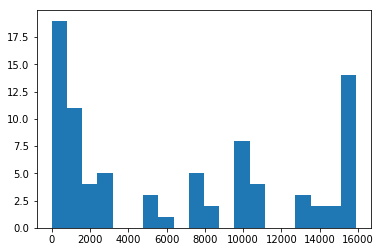

In [14]:
plt.hist(len_list, bins=20)

In [22]:
yelp_reviews = []
with open('./yelp_dataset/review.json') as data_file:    
    for line in data_file:
        data = json.loads(line)
        yelp_reviews.append(data)

In [57]:
yelp_business = []
with open('./yelp_dataset/business.json') as data_file:    
    for line in data_file:
        data = json.loads(line)
        yelp_business.append(data)

In [58]:
df_yelp_business = pd.DataFrame(yelp_business)

In [23]:
df_yelp_reviews = pd.DataFrame(yelp_reviews)

In [59]:
df_yelp = pd.merge(df_yelp_business, df_yelp_reviews, on='business_id')

In [ ]:
df_yelp['avg_review_count'] = df_yelp.groupby('postal_code')['review_count'].transform(np.mean)

In [ ]:
df_yelp.head()

In [54]:
df_yelp_business = df_yelp_business.sort_values('postal_code',ascending=False)
df_yelp_business = df_yelp_business.set_index('postal_code')

In [27]:
def build_feature_list(good_range, df_list):
    year_list = ['2011', '2012', '2013', '2014', '2015', '2016']
    feature_df_list = []
    bugs = []
    for num in good_range:
        df = df_list[num]
        try:
            df = df.loc[:, '1990-01':'2016-12']
            features = pd.DataFrame()
            for i, year in enumerate(year_list):
                mean = df.loc[:, year + '-01': year + '-12'].mean(axis=1)
                features[year + '_mean'] = mean
                std = df.loc[:, year + '-01': year + '-12'].std(axis=1)
                features[year + '_std'] = std
                mn = df.loc[:, year + '-01': year + '-12'].min(axis=1)
                features[year + '_min'] = mn
                mx = df.loc[:, year + '-01': year + '-12'].max(axis=1)
                features[year + '_max'] = mx
                features[year + '_swing'] = mx - mn
                change = df[year + '-12'] - df[year + '-01']
                features[year + '_change'] = change
                if i > 0:
                    yoy = features[year + '_mean'] / df.loc[:, year_list[i - 1] + '-01': year_list[i - 1] + '-12'].mean(axis=1)
                    features[year + '_yoy'] = yoy
                    features[year + '_gain'] = np.where(features[year + '_yoy']>1, 1, 0)
                    
                    #big swing and gain, big swing and loss, big swing and big gain, big swing and big loss
            feature_df_list.append(features)
        except:
            bugs.append(num)
    return feature_df_list, bugs

In [28]:
def build_feature_list_add(good_range, df_list, pure_feature_list):
    year_list = ['2011', '2012', '2013', '2014', '2015', '2016']
    feature_df_list = []
    bugs = []
    for feature in pure_feature_list:
        df = df_list[feature]
        feature_df_list.append(df)
    for num in good_range:
        df = df_list[num]
        try:
            df = df.loc[:, '2011-01':'2016-12']
            features = pd.DataFrame()
            for i, year in enumerate(year_list):
                mean = df.loc[:, year + '-01': year + '-12'].mean(axis=1)
                features[year + '_mean'] = mean
                std = df.loc[:, year + '-01': year + '-12'].std(axis=1)
                features[year + '_std'] = std
                mn = df.loc[:, year + '-01': year + '-12'].min(axis=1)
                features[year + '_min'] = mn
                mx = df.loc[:, year + '-01': year + '-12'].max(axis=1)
                features[year + '_max'] = mx
                features[year + '_swing'] = mx - mn
                change = df[year + '-12'] - df[year + '-01']
                features[year + '_change'] = change
                if i > 0:
                    yoy = features[year + '_mean'] / df.loc[:, year_list[i - 1] + '-01': year_list[i - 1] + '-12'].mean(axis=1)
                    features[year + '_yoy'] = yoy
                    features[year + '_gain'] = np.where(features[year + '_yoy']>1, 1, 0)
                    
            feature_df_list.append(features)
        except:
            bugs.append(num)
    return feature_df_list, bugs

In [29]:
def build_feature_list_bugs(good_range, df_list):
    year_list = ['2011', '2012', '2013', '2014', '2015', '2016']
    feature_df_list = []
    bugs = []
    for num in good_range:
        df = df_list[num]
        df = df.loc[:, '2011-01':'2016-12']
        features = pd.DataFrame()
        for i, year in enumerate(year_list):
            try:
                mean = df.loc[:, year + '-01': year + '-12'].mean(axis=1)
                features[year + '_mean'] = mean
                std = df.loc[:, year + '-01': year + '-12'].std(axis=1)
                features[year + '_std'] = std
                mn = df.loc[:, year + '-01': year + '-12'].min(axis=1)
                features[year + '_min'] = mn
                mx = df.loc[:, year + '-01': year + '-12'].max(axis=1)
                features[year + '_max'] = mx
                features[year + '_swing'] = mx - mn
                change = df[year + '-12'] - df[year + '-01']
                features[year + '_change'] = change
                if i > 0:
                    yoy = features[year + '_mean'] / df.loc[:, year_list[i - 1] + '-01': year_list[i - 1] + '-12'].mean(axis=1)
                    features[year + '_yoy'] = yoy
                    features[year + '_gain'] = np.where(features[year + '_yoy']>1, 1, 0)
                    
                feature_df_list.append(features)
            except:
                mean = df.loc[:, year + '-01': year + '-12'].mean(axis=1)
                features[year + '_mean'] = mean
                std = df.loc[:, year + '-01': year + '-12'].std(axis=1)
                features[year + '_std'] = std
                mn = df.loc[:, year + '-01': year + '-12'].min(axis=1)
                features[year + '_min'] = mn
                mx = df.loc[:, year + '-01': year + '-12'].max(axis=1)
                features[year + '_max'] = mx
                features[year + '_swing'] = mx - mn
                #change = df[year + '-12'] - df[year + '-01']
                features[year + '_change'] = change
                if i > 0:
                    yoy = features[year + '_mean'] / df.loc[:, year_list[i - 1] + '-01': year_list[i - 1] + '-12'].mean(axis=1)
                    features[year + '_yoy'] = yoy
                    features[year + '_gain'] = np.where(features[year + '_yoy']>1, 1, 0)
                
                feature_df_list.append(features)
        #    bugs.append(num)
    return feature_df_list, bugs

In [30]:
def build_feature_list_swing(good_range, df_list):
    year_list = ['2011', '2012', '2013', '2014', '2015', '2016']
    feature_df_list = []
    bugs = []
    for num in good_range:
        df = df_list[num]
        try:
            df = df.loc[:, '2011-01':'2016-12']
            features = pd.DataFrame()
            for i, year in enumerate(year_list):
                mean = df.loc[:, year + '-01': year + '-12'].mean(axis=1)
                features[year + '_mean'] = mean
                std = df.loc[:, year + '-01': year + '-12'].std(axis=1)
                features[year + '_std'] = std
                mn = df.loc[:, year + '-01': year + '-12'].min(axis=1)
                features[year + '_min'] = mn
                mx = df.loc[:, year + '-01': year + '-12'].max(axis=1)
                features[year + '_max'] = mx
                features[year + '_swing'] = mx - mn
                change = df[year + '-12'] - df[year + '-01']
                features[year + '_change'] = change
                if i > 0:
                    yoy = features[year + '_mean'] / df.loc[:, year_list[i - 1] + '-01': year_list[i - 1] + '-12'].mean(axis=1)
                    features[year + '_yoy'] = yoy
                    features[year + '_gain'] = np.where(features[year + '_yoy']>1, 1, 0)
                    mean_yoy = features[year + '_yoy'].mean()
                    features[year + '_yoy_pos'] = np.where(features[year + '_yoy']>mean_yoy, 1, 0)
                    big_yoy = features[year + '_yoy'].std() + mean_yoy
                    features[year + '_yoy_big'] = np.where(features[year + '_yoy']>big_yoy, 1, 0)
                    features[year + '_yoy_neg'] = np.where(features[year + '_yoy']<mean_yoy, 1, 0)
                    big_loss = mean_yoy - features[year + '_yoy'].std() 
                    features[year + '_yoy_loss_big'] = np.where(features[year + '_yoy']<big_loss, 1, 0)
                mean_swing = features[year + '_swing'].mean()
                features[year + '_swing_pos'] = np.where(features[year + '_swing']>mean_swing, 1, 0)
                big_swing = features[year + '_swing'].std() + mean_swing
                features[year + '_swing_big'] = np.where(features[year + '_swing']>big_swing, 1, 0)
                features[year + '_swing_neg'] = np.where(features[year + '_swing']<mean_swing, 1, 0)
                swing_big_loss = mean_swing - features[year + '_swing'].std() 
                features[year + '_swing_loss_big'] = np.where(features[year + '_swing']<swing_big_loss, 1, 0)
            feature_df_list.append(features)
        except:
            bugs.append(num)
    return feature_df_list, bugs

In [31]:
len(useful_df)
for num in range(len(useful_df)):
    useful_df[num].dropna(inplace=True)

In [32]:
sixteen_doc_features, bugs = build_feature_list_swing(sixteen_list, useful_df)

In [33]:
len(bugs)

18

In [34]:
len(sixteen_doc_features)

12

In [35]:
list_of_file_names[77]

'./zip_2/Zip_Zri_AllHomesPlusMultifamily_Summary.csv'

In [36]:
# Docs that don't need feature engineering. They are already aggregates
pure_features = [0, 71, 75, 77, 79, 81]
sixteen_doc_features[1].head()

,2011_mean,2011_std,2011_min,2011_max,2011_swing,2011_change,2011_swing_pos,2011_swing_big,2011_swing_neg,2011_swing_loss_big,...,2016_yoy,2016_gain,2016_yoy_pos,2016_yoy_big,2016_yoy_neg,2016_yoy_loss_big,2016_swing_pos,2016_swing_big,2016_swing_neg,2016_swing_loss_big
RegionName,,,,,,,,,,,,,,,,,,,,,
99709,221412.500000,12083.763054,206950.0,240950.0,34000.0,-5550.0,1,0,0,0,...,1.042953,1,1,0,0,0,0,0,1,0
99705,228991.666667,4901.847209,219900.0,234900.0,15000.0,-3000.0,0,0,1,0,...,1.007205,1,0,0,1,0,0,0,1,0
99701,177891.666667,12940.595626,149900.0,191500.0,41600.0,-32600.0,1,0,0,0,...,1.052968,1,1,0,0,0,0,0,1,0
99669,242495.833333,8514.091483,225000.0,252000.0,27000.0,-3000.0,0,0,1,0,...,0.973424,0,0,0,1,1,0,0,1,0
99654,224546.458333,6069.795981,209500.0,232250.0,22750.0,15500.0,0,0,1,0,...,1.018328,1,0,0,1,0,0,0,1,0


In [180]:
useful_df[52].head()

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01
RegionName,,,,,,,,,,,,,,,,,,,,,
99901,162.0,162.0,162.0,162.0,162.0,162.0,162.0,162.0,162.0,162.0,...,161.0,162.0,162.0,162.0,162.0,162.0,162.0,161.0,161.0,161.0
99801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,206.0,207.0,208.0,209.0,210.0,211.0,212.0,212.0,211.0,211.0
99712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,123.0,122.0,122.0,122.0,120.0,120.0,120.0,120.0,120.0,120.0
99709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,119.0,119.0,119.0,119.0,119.0,118.0,118.0,118.0,119.0,119.0
99705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,124.0,124.0,124.0,123.0,123.0,123.0,122.0,123.0,123.0,124.0


In [37]:
len(sixteen_doc_features)
for num in range(len(sixteen_doc_features)):
    sixteen_doc_features[num].dropna(inplace=True)

In [38]:
# Merging all dfs into one. Merging on indez which is zipcode. I was hoping for inner join but it looks like
# There are many zipcodes that only exist in certain dfs. Im hoping that reducing them to metro areas will fix this
def merge_dataframes(feature_df_list):
    df_1 = feature_df_list[0]
    for df in feature_df_list[1:]:
        df_1 = pd.merge(df_1, df, left_index=True, right_index=True, how='inner')
    
    return df_1

In [39]:
X_16 = merge_dataframes(sixteen_doc_features)

In [40]:
X_16.dropna(inplace=True)

In [41]:
X_16.isnull().sum().sum()

0

In [42]:
X_16.head()

,2011_mean_x,2011_std_x,2011_min_x,2011_max_x,2011_swing_x,2011_change_x,2011_swing_pos_x,2011_swing_big_x,2011_swing_neg_x,2011_swing_loss_big_x,...,2016_yoy_y,2016_gain_y,2016_yoy_pos_y,2016_yoy_big_y,2016_yoy_neg_y,2016_yoy_loss_big_y,2016_swing_pos_y,2016_swing_big_y,2016_swing_neg_y,2016_swing_loss_big_y
RegionName,,,,,,,,,,,,,,,,,,,,,
99223,17.470575,2.151552,13.157744,19.884243,6.726499,0.772589,0,0,1,0,...,1.050296,1,1,0,0,0,1,0,0,0
99218,17.800899,2.953572,11.325792,21.163550,9.837757,2.571792,1,0,0,0,...,1.057409,1,1,0,0,0,1,0,0,0
99217,16.730506,2.461923,11.315092,20.255591,8.940499,-2.257172,0,0,1,0,...,1.035182,1,1,0,0,0,0,0,1,0
99212,15.310737,2.952748,11.290826,20.327481,9.036655,0.120253,0,0,1,0,...,1.044389,1,1,0,0,0,0,0,1,0
99208,12.623406,1.774491,9.810553,15.617595,5.807042,1.675172,0,0,1,1,...,1.048049,1,1,0,0,0,0,0,1,0


In [43]:
df_yelp_business = df_yelp_business.sort_values('postal_code',ascending=False)
df_yelp_business = df_yelp_business.set_index('postal_code')

In [44]:
df_yelp_business_merge = pd.DataFrame()
df_yelp_business_merge['review_count'] = df_yelp_business['review_count']

In [45]:
df_yelp_business_merge.head()

,review_count
postal_code,
YO22 5LY,4
YO22 5AL,4
YO22 4RG,3
YO22 4NT,3
YO22 4JT,15


In [924]:
df_yelp_business_merge.tail(50)

,review_count,zeroes


In [711]:
X_16.index

Int64Index([99362, 99354, 99352, 99337, 99224, 99223, 99218, 99217, 99216,
            99212,
            ...
             1077,  1075,  1069,  1056,  1040,  1028,  1020,  1013,  1002,
             1001],
           dtype='int64', name='RegionName', length=4149)

In [47]:
# Merging the Zillow data and the yelp zipcodes 
df_2 = pd.merge(X_16, df_yelp_business_merge, left_index=True, right_index=True, how='inner')

In [48]:
df_2.head()

,2011_mean_x,2011_std_x,2011_min_x,2011_max_x,2011_swing_x,2011_change_x,2011_swing_pos_x,2011_swing_big_x,2011_swing_neg_x,2011_swing_loss_big_x,...,2016_gain_y,2016_yoy_pos_y,2016_yoy_big_y,2016_yoy_neg_y,2016_yoy_loss_big_y,2016_swing_pos_y,2016_swing_big_y,2016_swing_neg_y,2016_swing_loss_big_y,review_count
15102,15.066711,2.11167,11.889551,19.036276,7.146725,-1.048499,0,0,1,0,...,1,0,0,1,0,0,0,1,0,3
15102,15.066711,2.11167,11.889551,19.036276,7.146725,-1.048499,0,0,1,0,...,1,0,0,1,0,0,0,1,0,9
15102,15.066711,2.11167,11.889551,19.036276,7.146725,-1.048499,0,0,1,0,...,1,0,0,1,0,0,0,1,0,15
15102,15.066711,2.11167,11.889551,19.036276,7.146725,-1.048499,0,0,1,0,...,1,0,0,1,0,0,0,1,0,4
15102,15.066711,2.11167,11.889551,19.036276,7.146725,-1.048499,0,0,1,0,...,1,0,0,1,0,0,0,1,0,4


In [75]:
def make_features(df_list, good_range, past_time_string, now_string):
    feature_df_list = []
    bugs = []
    for num in good_range:
        df = df_list[num]
        df = df.loc[:, :now_string]
        try:
            features = pd.DataFrame()
            mean = df.loc[:, past_time_string : now_string].mean(axis=1)
            features[now_string + '_mean'] = mean
            std = df.loc[:, past_time_string : now_string].std(axis=1)
            features[now_string + '_std'] = std
            mn = df.loc[:, past_time_string : now_string].min(axis=1)
            features[now_string + '_min'] = mn
            mx = df.loc[:, past_time_string : now_string].max(axis=1)
            features[now_string + '_max'] = mx
            features[now_string + '_swing'] = mx - mn
            change = df[now_string] - df[past_time_string]
            features[now_string + '_change'] = change
            feature_df_list.append(features)
                
        except:
            bugs.append(num)
    return features_df_list
    

def make_modeling_data(df, df_features, now_string):
    now_time = pd.to_datetime(now_string)
    now_value = df[now_string]
    
    future_time = now_time + timedelta(days=6*31)
    future_time_string= future_time.strftime("%Y-%m")
    past_time = now_time - timedelta(days=6*31)
    past_time_string= past_time.strftime("%Y-%m")
    past_value = df[past_time_string]
    future_value = df[future_time_string]
   
    target = future_value/now_value
    
    #df_to_use_for_features= df_features.loc[:, :now_string]
    
    features = make_features(df_features, sixteen_list, past_time_string, now_string)
    
    return features, target




test_features, test_targets = make_modeling_data(useful_df[23], useful_df, "2017-01")
train_features, train_targets = make_modeling_data(useful_df[23], useful_df, "2016-07")

#for year in ["2014",'2015',"2016"]:
 #   for month in ["01",'07']:
  #      extra_train_features, extra_train_targets = make_modeling_data(read_data_list_2[3], year+"-"+month)
   #     train_features = train_features.append(extra_train_features)
    #    train_targets = train_targets.append(extra_train_targets)

KeyError: '2017-01'

In [47]:
len(windows[1])

10521

In [42]:
len(windows[2])

10521

In [ ]:
window_list

In [80]:
y = create_y_ratio(read_data_list_2[23])

KeyError: 1513.2575757575798

In [70]:
len(read_data_list_2[23])

10521

In [67]:
y.head()

,RegionName,y
0,10025,0.950185
1,60657,NaN
2,10023,0.995899
3,77494,1.031827
4,75070,0.981885


In [50]:
X_16_df = pd.merge(X_16, y, right_index=True, left_index=True, how='inner')

NameError: name 'y' is not defined

In [964]:
X_2_df = pd.merge(df_2, y, right_index=True, left_index=True, how='inner')

In [966]:
X_2_df.head()

,2011_mean_x,2011_std_x,2011_min_x,2011_max_x,2011_swing_x,2011_change_x,2011_swing_pos_x,2011_swing_big_x,2011_swing_neg_x,2011_swing_loss_big_x,...,2016_yoy_pos_y,2016_yoy_big_y,2016_yoy_neg_y,2016_yoy_loss_big_y,2016_swing_pos_y,2016_swing_big_y,2016_swing_neg_y,2016_swing_loss_big_y,review_count,y
15003,13.663362,3.136821,10.19523,18.892134,8.696905,-2.455884,0,0,1,0,...,0,0,1,0,0,0,1,0,4,1.004622
15003,13.663362,3.136821,10.19523,18.892134,8.696905,-2.455884,0,0,1,0,...,0,0,1,0,0,0,1,0,8,1.004622
15003,13.663362,3.136821,10.19523,18.892134,8.696905,-2.455884,0,0,1,0,...,0,0,1,0,0,0,1,0,39,1.004622
15003,13.663362,3.136821,10.19523,18.892134,8.696905,-2.455884,0,0,1,0,...,0,0,1,0,0,0,1,0,3,1.004622
15003,13.663362,3.136821,10.19523,18.892134,8.696905,-2.455884,0,0,1,0,...,0,0,1,0,0,0,1,0,8,1.004622


In [948]:
X_2.dropna(inplace=True)
X_2.isnull().sum().sum()
X_2.describe()

AttributeError: 'numpy.ndarray' object has no attribute 'dropna'

In [737]:
X_2_df['2016_gain'].sum() / len(X_2_df)

0.9347079037800687

In [818]:
X_16_df.dropna(inplace=True)
X_16_df.isnull().sum().sum()
X_16_df.describe()

,2011_mean_x,2011_std_x,2011_min_x,2011_max_x,2011_swing_x,2011_change_x,2011_swing_pos_x,2011_swing_big_x,2011_swing_neg_x,2011_swing_loss_big_x,...,2016_gain_y,2016_yoy_pos_y,2016_yoy_big_y,2016_yoy_neg_y,2016_yoy_loss_big_y,2016_swing_pos_y,2016_swing_big_y,2016_swing_neg_y,2016_swing_loss_big_y,y
count,5129.000000,5129.000000,5129.000000,5129.000000,5129.000000,5129.000000,5129.000000,5129.000000,5129.000000,5129.000000,...,5129.000000,5129.000000,5129.000000,5129.000000,5129.000000,5129.000000,5129.000000,5129.000000,5129.000000,5129.000000
mean,14.281579,2.873584,9.687841,19.192768,9.504927,-1.164982,0.428154,0.149152,0.571846,0.149152,...,0.872685,0.551764,0.156561,0.448236,0.049912,0.360889,0.098265,0.639111,0.021252,1.067475
std,3.122251,1.019149,3.194033,4.072836,3.459762,4.325728,0.494859,0.356273,0.494859,0.356273,...,0.333358,0.497362,0.363422,0.497362,0.217785,0.480305,0.297701,0.480305,0.144236,0.072273
min,5.149246,0.717761,-1.717095,7.217994,2.280413,-23.062877,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.791820
25%,12.116049,2.138989,7.456067,16.480570,7.036975,-3.732543,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.023399
50%,14.286639,2.739566,9.738339,19.012437,9.001742,-0.989435,0.000000,0.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.061971
75%,16.355682,3.455925,11.863632,21.755320,11.443071,1.592072,1.000000,0.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.106317
max,25.309110,9.054726,21.888196,38.354467,32.033667,17.008037,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.425089


In [967]:
X_2 = X_2_df.iloc[:, :-1].values
y_2 = X_2_df.iloc[:, -1].values

In [820]:
X_16 = X_16_df.iloc[:, :-1].values
y_16 = X_16_df.iloc[:, -1].values

In [968]:
X_2_df['y'].describe()

count    97745.000000
mean         1.091032
std          0.069050
min          0.884748
25%          1.047925
50%          1.073544
75%          1.123171
max          1.425089
Name: y, dtype: float64

In [828]:
X_16_df['y'].describe()

count    5129.000000
mean        1.067475
std         0.072273
min         0.791820
25%         1.023399
50%         1.061971
75%         1.106317
max         1.425089
Name: y, dtype: float64

In [521]:
X_16_df

array([[  1.98408333e+01,   5.28288568e+00,   1.26100000e+01, ...,
          4.44783710e-02,   1.11710935e+00,   1.00000000e+00],
       [  8.59416667e+00,   2.68156148e+00,   4.90000000e+00, ...,
          3.36152944e-02,   1.16117045e+00,   1.00000000e+00],
       [  9.57916667e+00,   4.12912815e+00,   4.05000000e+00, ...,
          2.08722085e-02,   1.76863352e+00,   1.00000000e+00],
       ..., 
       [  3.84833333e+00,   7.56057457e+00,   3.00000000e-02, ...,
         -1.84320184e-02,   2.15476923e+01,   1.00000000e+00],
       [  7.37000000e+00,   8.97160267e+00,   1.15000000e+00, ...,
          1.24468539e-02,   9.77659456e-01,   0.00000000e+00],
       [  2.06333333e+00,   1.31138604e+00,   6.10000000e-01, ...,
         -1.59529241e-02,   8.84642600e-01,   0.00000000e+00]])

In [774]:
def norm_per_column(X):
    new_array = []
    shape = X.shape
    columns = shape[1]
    for num in range(columns):
        mx = X[:, num].max()
        if mx == 0:
            new_array.append(X[:, num])
        else:
            X[:, num] = X[:, num] / mx
            new_array.append(X[:, num])
    new_array = np.array(new_array)
    new_array = np.transpose(new_array)
    return new_array

In [969]:
X_2 = norm_per_column(X_2)

In [858]:
X_16 = norm_per_column(X_16)

In [810]:
X_16.shape

(5129, 540)

In [951]:
X_2

array([], shape=(0, 541), dtype=float64)

In [821]:
X_16.max()

12984.457456492662

In [857]:
X_16 = X_16 * 12900

In [724]:
X_2 = X_2 / 400000

In [584]:
X_16_df = X_16_df / 94650

In [725]:
X_2.max()

1.0

In [977]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size= .2, shuffle=False)

In [859]:
X_train_16, X_test_16, y_train_16, y_test_16 = train_test_split(X_16, y_16, test_size= .2)

In [860]:
# Hold overfit model for now
model = Sequential()
model.add(Dense(3000, input_shape=(540,), activation='relu'))
model.add(Dense(2000, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer='Adam',
              loss='mean_squared_error')

In [ ]:
model = Sequential()
model.add(Dense(1000, input_shape=(540,), activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer='Adam',
              loss='mean_squared_error')

In [870]:
model.fit(x=X_train_16, y=y_train_16, 
          batch_size=2500, 
          epochs=100, 
          verbose=1, 
          validation_data=(X_test_16, y_test_16),
          callbacks=None)

Train on 4103 samples, validate on 1026 samples
Epoch 1/100
4103/4103 [==============================] - 6s 1ms/step - loss: 2.9291e-04 - val_loss: 0.3209
Epoch 2/100
4103/4103 [==============================] - 6s 1ms/step - loss: 1.0620e-04 - val_loss: 0.3204
Epoch 3/100
4103/4103 [==============================] - 6s 1ms/step - loss: 2.8823e-05 - val_loss: 0.3209
Epoch 4/100
4103/4103 [==============================] - 6s 1ms/step - loss: 1.0509e-04 - val_loss: 0.3214
Epoch 5/100
4103/4103 [==============================] - 6s 1ms/step - loss: 1.9939e-04 - val_loss: 0.3217
Epoch 6/100
4103/4103 [==============================] - 6s 1ms/step - loss: 2.1241e-04 - val_loss: 0.3213
Epoch 7/100
4103/4103 [==============================] - 6s 1ms/step - loss: 1.4091e-04 - val_loss: 0.3196
Epoch 8/100
4103/4103 [==============================] - 6s 1ms/step - loss: 6.1681e-05 - val_loss: 0.3184
Epoch 9/100
4103/4103 [==============================] - 6s 1ms/step - loss: 2.4459e-05 - val_lo

In [ ]:
#loss = .00001441 (overfit) = .0038

#std = .072

In [978]:
# Adding reviews. No overfit! 
model = Sequential()
model.add(Dense(3000, input_shape=(541,), activation='relu'))
model.add(Dense(2000, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer='Adam',
              loss='mean_squared_error')

In [980]:
model.fit(x=X_train_2, y=y_train_2, 
          batch_size=2500, 
          epochs=1000, 
          verbose=1, 
          validation_data=(X_test_2, y_test_2),
          callbacks=None)

Train on 78196 samples, validate on 19549 samples
Epoch 1/1000
78196/78196 [==============================] - 109s 1ms/step - loss: 4.7343 - val_loss: 0.0027
Epoch 2/1000
78196/78196 [==============================] - 109s 1ms/step - loss: 0.0937 - val_loss: 0.0046
Epoch 3/1000
78196/78196 [==============================] - 109s 1ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 4/1000
78196/78196 [==============================] - 109s 1ms/step - loss: 3.2574e-04 - val_loss: 0.0059
Epoch 5/1000
78196/78196 [==============================] - 109s 1ms/step - loss: 7.3467e-05 - val_loss: 0.0059
Epoch 6/1000
78196/78196 [==============================] - 109s 1ms/step - loss: 4.5027e-05 - val_loss: 0.0060
Epoch 7/1000
78196/78196 [==============================] - 109s 1ms/step - loss: 3.2798e-05 - val_loss: 0.0061
Epoch 8/1000
78196/78196 [==============================] - 109s 1ms/step - loss: 2.5425e-05 - val_loss: 0.0062
Epoch 9/1000
78196/78196 [==============================] - 109s 1

78196/78196 [==============================] - 198s 3ms/step - loss: 8.0601e-07 - val_loss: 0.0074
Epoch 74/1000
78196/78196 [==============================] - 188s 2ms/step - loss: 4.5826e-07 - val_loss: 0.0073
Epoch 75/1000
78196/78196 [==============================] - 191s 2ms/step - loss: 1.0517e-04 - val_loss: 0.0065
Epoch 76/1000
78196/78196 [==============================] - 196s 3ms/step - loss: 3.7467e-05 - val_loss: 0.0073
Epoch 77/1000
78196/78196 [==============================] - 188s 2ms/step - loss: 2.5486e-06 - val_loss: 0.0073
Epoch 78/1000
67500/78196 [========================>.....] - ETA: 26s - loss: 4.9238e-07

KeyboardInterrupt: 

In [ ]:
# Val_loss = .00000306
# loss = .000000415
# STD = .069

In [557]:
model = Sequential()
model.add(Dense(64, input_shape=(90,), activation='relu'))
model.add(Dropout(.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(256, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(2000, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(1, activation='linear'))
sgd = keras.optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd,
              loss='mean_squared_error')

In [558]:
model.fit(x=X_train_s, y=y_train_s, 
          batch_size=2500, 
          epochs=2000, 
          verbose=1, 
          validation_data=(X_test_s, y_test_s),
          callbacks=None)

Train on 5336 samples, validate on 1334 samples
Epoch 1/2000
5336/5336 [==============================] - 5s 906us/step - loss: 1.0742 - val_loss: 0.8664
Epoch 2/2000
5336/5336 [==============================] - 3s 483us/step - loss: 0.8218 - val_loss: 0.6511
Epoch 3/2000
5336/5336 [==============================] - 3s 483us/step - loss: 0.6200 - val_loss: 0.4853
Epoch 4/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.4641 - val_loss: 0.3586
Epoch 5/2000
5336/5336 [==============================] - 3s 482us/step - loss: 0.3450 - val_loss: 0.2620
Epoch 6/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.2540 - val_loss: 0.1897
Epoch 7/2000
5336/5336 [==============================] - 3s 482us/step - loss: 0.1856 - val_loss: 0.1357
Epoch 8/2000
5336/5336 [==============================] - 3s 491us/step - loss: 0.1340 - val_loss: 0.0961
Epoch 9/2000
5336/5336 [==============================] - 3s 488us/step - loss: 0.0967 - val_loss: 0.067

5336/5336 [==============================] - 3s 484us/step - loss: 0.0056 - val_loss: 0.0049
Epoch 154/2000
5336/5336 [==============================] - 3s 481us/step - loss: 0.0055 - val_loss: 0.0049
Epoch 155/2000
5336/5336 [==============================] - 3s 481us/step - loss: 0.0056 - val_loss: 0.0049
Epoch 156/2000
5336/5336 [==============================] - 3s 483us/step - loss: 0.0056 - val_loss: 0.0049
Epoch 157/2000
5336/5336 [==============================] - 3s 482us/step - loss: 0.0056 - val_loss: 0.0049
Epoch 158/2000
5336/5336 [==============================] - 3s 497us/step - loss: 0.0056 - val_loss: 0.0049
Epoch 159/2000
5336/5336 [==============================] - 3s 499us/step - loss: 0.0055 - val_loss: 0.0049
Epoch 160/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0056 - val_loss: 0.0049
Epoch 161/2000
5336/5336 [==============================] - 3s 484us/step - loss: 0.0056 - val_loss: 0.0049
Epoch 162/2000
5336/5336 [=================

Epoch 229/2000
5336/5336 [==============================] - 3s 490us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 230/2000
5336/5336 [==============================] - 3s 489us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 231/2000
5336/5336 [==============================] - 3s 482us/step - loss: 0.0055 - val_loss: 0.0049
Epoch 232/2000
5336/5336 [==============================] - 3s 481us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 233/2000
5336/5336 [==============================] - 3s 499us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 234/2000
5336/5336 [==============================] - 3s 483us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 235/2000
5336/5336 [==============================] - 3s 484us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 236/2000
5336/5336 [==============================] - 3s 484us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 237/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 238/2000
5336/5336 [==

Epoch 305/2000
5336/5336 [==============================] - 3s 484us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 306/2000
5336/5336 [==============================] - 3s 484us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 307/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 308/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 309/2000
5336/5336 [==============================] - 3s 487us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 310/2000
5336/5336 [==============================] - 3s 492us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 311/2000
5336/5336 [==============================] - 3s 483us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 312/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 313/2000
5336/5336 [==============================] - 3s 484us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 314/2000
5336/5336 [==

Epoch 381/2000
5336/5336 [==============================] - 3s 484us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 382/2000
5336/5336 [==============================] - 3s 486us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 383/2000
5336/5336 [==============================] - 3s 483us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 384/2000
5336/5336 [==============================] - 3s 496us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 385/2000
5336/5336 [==============================] - 3s 484us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 386/2000
5336/5336 [==============================] - 3s 483us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 387/2000
5336/5336 [==============================] - 3s 481us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 388/2000
5336/5336 [==============================] - 3s 484us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 389/2000
5336/5336 [==============================] - 3s 493us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 390/2000
5336/5336 [==

Epoch 457/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 458/2000
5336/5336 [==============================] - 3s 487us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 459/2000
5336/5336 [==============================] - 3s 482us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 460/2000
5336/5336 [==============================] - 3s 483us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 461/2000
5336/5336 [==============================] - 3s 493us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 462/2000
5336/5336 [==============================] - 3s 483us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 463/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 464/2000
5336/5336 [==============================] - 3s 482us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 465/2000
5336/5336 [==============================] - 3s 495us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 466/2000
5336/5336 [==

Epoch 533/2000
5336/5336 [==============================] - 3s 486us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 534/2000
5336/5336 [==============================] - 3s 486us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 535/2000
5336/5336 [==============================] - 3s 497us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 536/2000
5336/5336 [==============================] - 3s 486us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 537/2000
5336/5336 [==============================] - 3s 484us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 538/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 539/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 540/2000
5336/5336 [==============================] - 3s 482us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 541/2000
5336/5336 [==============================] - 3s 482us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 542/2000
5336/5336 [==

Epoch 609/2000
5336/5336 [==============================] - 3s 517us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 610/2000
5336/5336 [==============================] - 3s 592us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 611/2000
5336/5336 [==============================] - 3s 487us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 612/2000
5336/5336 [==============================] - 3s 494us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 613/2000
5336/5336 [==============================] - 3s 488us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 614/2000
5336/5336 [==============================] - 3s 519us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 615/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 616/2000
5336/5336 [==============================] - 3s 510us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 617/2000
5336/5336 [==============================] - 3s 490us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 618/2000
5336/5336 [==

Epoch 685/2000
5336/5336 [==============================] - 3s 487us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 686/2000
5336/5336 [==============================] - 3s 494us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 687/2000
5336/5336 [==============================] - 3s 487us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 688/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 689/2000
5336/5336 [==============================] - 3s 486us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 690/2000
5336/5336 [==============================] - 3s 486us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 691/2000
5336/5336 [==============================] - 3s 491us/step - loss: 0.0056 - val_loss: 0.0048
Epoch 692/2000
5336/5336 [==============================] - 3s 487us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 693/2000
5336/5336 [==============================] - 3s 493us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 694/2000
5336/5336 [==

Epoch 761/2000
5336/5336 [==============================] - 3s 493us/step - loss: 0.0055 - val_loss: 0.0048
Epoch 762/2000
5336/5336 [==============================] - 3s 513us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 763/2000
5336/5336 [==============================] - 3s 553us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 764/2000
5336/5336 [==============================] - 3s 557us/step - loss: 0.0056 - val_loss: 0.0047
Epoch 765/2000
5336/5336 [==============================] - 3s 489us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 766/2000
5336/5336 [==============================] - 3s 523us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 767/2000
5336/5336 [==============================] - 3s 528us/step - loss: 0.0056 - val_loss: 0.0047
Epoch 768/2000
5336/5336 [==============================] - 3s 516us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 769/2000
5336/5336 [==============================] - 3s 509us/step - loss: 0.0056 - val_loss: 0.0047
Epoch 770/2000
5336/5336 [==

Epoch 837/2000
5336/5336 [==============================] - 3s 491us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 838/2000
5336/5336 [==============================] - 3s 487us/step - loss: 0.0056 - val_loss: 0.0047
Epoch 839/2000
5336/5336 [==============================] - 3s 492us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 840/2000
5336/5336 [==============================] - 3s 495us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 841/2000
5336/5336 [==============================] - 3s 487us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 842/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 843/2000
5336/5336 [==============================] - 3s 520us/step - loss: 0.0056 - val_loss: 0.0047
Epoch 844/2000
5336/5336 [==============================] - 3s 484us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 845/2000
5336/5336 [==============================] - 3s 487us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 846/2000
5336/5336 [==

Epoch 913/2000
5336/5336 [==============================] - 3s 484us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 914/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 915/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 916/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 917/2000
5336/5336 [==============================] - 3s 486us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 918/2000
5336/5336 [==============================] - 3s 486us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 919/2000
5336/5336 [==============================] - 3s 489us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 920/2000
5336/5336 [==============================] - 3s 497us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 921/2000
5336/5336 [==============================] - 3s 490us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 922/2000
5336/5336 [==

Epoch 989/2000
5336/5336 [==============================] - 3s 494us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 990/2000
5336/5336 [==============================] - 3s 499us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 991/2000
5336/5336 [==============================] - 3s 496us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 992/2000
5336/5336 [==============================] - 3s 489us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 993/2000
5336/5336 [==============================] - 3s 497us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 994/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 995/2000
5336/5336 [==============================] - 3s 488us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 996/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 997/2000
5336/5336 [==============================] - 3s 487us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 998/2000
5336/5336 [==

5336/5336 [==============================] - 3s 485us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1140/2000
5336/5336 [==============================] - 3s 494us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1141/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1142/2000
5336/5336 [==============================] - 3s 487us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1143/2000
5336/5336 [==============================] - 3s 481us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1144/2000
5336/5336 [==============================] - 3s 499us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 1145/2000
5336/5336 [==============================] - 3s 488us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1146/2000
5336/5336 [==============================] - 3s 483us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1147/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0056 - val_loss: 0.0047
Epoch 1148/2000
5336/5336 [========

5336/5336 [==============================] - 3s 486us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1290/2000
5336/5336 [==============================] - 3s 494us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 1291/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1292/2000
5336/5336 [==============================] - 3s 484us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1293/2000
5336/5336 [==============================] - 3s 484us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 1294/2000
5336/5336 [==============================] - 3s 496us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1295/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1296/2000
5336/5336 [==============================] - 3s 489us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1297/2000
5336/5336 [==============================] - 3s 486us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 1298/2000
5336/5336 [========

5336/5336 [==============================] - 3s 483us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1440/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 1441/2000
5336/5336 [==============================] - 3s 491us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1442/2000
5336/5336 [==============================] - 3s 482us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 1443/2000
5336/5336 [==============================] - 3s 489us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1444/2000
5336/5336 [==============================] - 3s 488us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 1445/2000
5336/5336 [==============================] - 3s 491us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 1446/2000
5336/5336 [==============================] - 3s 488us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 1447/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1448/2000
5336/5336 [========

5336/5336 [==============================] - 3s 490us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 1590/2000
5336/5336 [==============================] - 3s 486us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1591/2000
5336/5336 [==============================] - 3s 481us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 1592/2000
5336/5336 [==============================] - 3s 490us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 1593/2000
5336/5336 [==============================] - 3s 486us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1594/2000
5336/5336 [==============================] - 3s 488us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 1595/2000
5336/5336 [==============================] - 3s 494us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1596/2000
5336/5336 [==============================] - 3s 493us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1597/2000
5336/5336 [==============================] - 3s 486us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1598/2000
5336/5336 [========

5336/5336 [==============================] - 3s 487us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1740/2000
5336/5336 [==============================] - 3s 487us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 1741/2000
5336/5336 [==============================] - 3s 494us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1742/2000
5336/5336 [==============================] - 3s 495us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1743/2000
5336/5336 [==============================] - 3s 489us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 1744/2000
5336/5336 [==============================] - 3s 490us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1745/2000
5336/5336 [==============================] - 3s 485us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1746/2000
5336/5336 [==============================] - 3s 499us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1747/2000
5336/5336 [==============================] - 3s 487us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1748/2000
5336/5336 [========

5336/5336 [==============================] - 3s 483us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1890/2000
5336/5336 [==============================] - 3s 486us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 1891/2000
5336/5336 [==============================] - 3s 484us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1892/2000
5336/5336 [==============================] - 3s 487us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 1893/2000
5336/5336 [==============================] - 3s 497us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 1894/2000
5336/5336 [==============================] - 3s 489us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1895/2000
5336/5336 [==============================] - 3s 489us/step - loss: 0.0054 - val_loss: 0.0047
Epoch 1896/2000
5336/5336 [==============================] - 3s 488us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1897/2000
5336/5336 [==============================] - 3s 501us/step - loss: 0.0055 - val_loss: 0.0047
Epoch 1898/2000
5336/5336 [========

In [89]:
X_train_16, X_test_16, y_train_16, y_test_16 = train_test_split(X_16, y_16, test_size= .2)

In [726]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size= .3)

In [136]:
y_16

array([ 1.05329405,  1.12662344,  1.08065202, ...,  0.99302723,
        1.0074516 ,  1.07181999])

In [796]:
y_train_16.max()

1.2498697469914781

In [528]:
.0055 ** .5

0.07416198487095663

In [510]:
# New datasets
model = Sequential()
model.add(Dense(64, input_shape=(690,), activation='relu'))
model.add(Dropout(.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(256, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(2000, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(1, activation='linear'))
# best lr .02
sgd = keras.optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd,
              loss='mean_squared_error')

In [341]:
# New datasets
model = Sequential()
model.add(Dense(64, input_shape=(1350,), activation='relu'))
model.add(Dropout(.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(256, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(2000, activation='relu'))
# Added
model.add(Dense(2000, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(1, activation='linear'))
# best lr .005
sgd = keras.optimizers.SGD(lr=0.005)
model.compile(optimizer=sgd,
              loss='mean_squared_error')

In [791]:
# New datasets
model = Sequential()
model.add(Dense(64, input_shape=(875,), activation='relu'))
model.add(Dropout(.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(256, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(2000, activation='relu'))
# Added
model.add(Dense(2000, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(1, activation='linear'))
# best lr .005
sgd = keras.optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd,
              loss='mean_squared_error')

In [794]:
model.fit(x=X_train_16, y=y_train_16, 
          batch_size=300, 
          epochs=30, 
          verbose=1, 
          validation_data=(X_test_16, y_test_16),
          callbacks=None)



Train on 662 samples, validate on 166 samples
Epoch 1/30
662/662 [==============================] - 1s 2ms/step - loss: 0.0177 - val_loss: 0.0591
Epoch 2/30
662/662 [==============================] - 1s 1ms/step - loss: 0.0183 - val_loss: 0.0606
Epoch 3/30
662/662 [==============================] - 1s 1ms/step - loss: 0.0183 - val_loss: 0.0574
Epoch 4/30
662/662 [==============================] - 1s 1ms/step - loss: 0.0169 - val_loss: 0.0568
Epoch 5/30
662/662 [==============================] - 1s 1ms/step - loss: 0.0182 - val_loss: 0.0587
Epoch 6/30
662/662 [==============================] - 1s 1ms/step - loss: 0.0191 - val_loss: 0.0616
Epoch 7/30
662/662 [==============================] - 1s 1ms/step - loss: 0.0210 - val_loss: 0.0591
Epoch 8/30
662/662 [==============================] - 1s 1ms/step - loss: 0.0187 - val_loss: 0.0579
Epoch 9/30
662/662 [==============================] - 1s 1ms/step - loss: 0.0167 - val_loss: 0.0570
Epoch 10/30
662/662 [==============================] -

In [311]:
# Without new features
root = .0040 ** .5
# .071
root

In [417]:
X_16['y'].describe()

count    2400.000000
mean        1.066686
std         0.065818
min         0.831398
25%         1.024956
50%         1.061385
75%         1.101586
max         1.425089
Name: y, dtype: float64

In [561]:
# new datasets with new features (big swing)
model = Sequential()
model.add(Dense(64, input_shape=(450,), activation='relu'))
model.add(Dropout(.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(256, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(2000, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(1, activation='relu'))

sgd = keras.optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd,
              loss='mean_squared_error')

In [562]:
model.fit(x=X_train_sm, y=y_train_sm, 
          batch_size=2500, 
          epochs=2000, 
          verbose=1, 
          validation_data=(X_test_sm, y_test_sm),
          callbacks=None)



Train on 2186 samples, validate on 547 samples
Epoch 1/2000
2186/2186 [==============================] - 3s 2ms/step - loss: 1.1054 - val_loss: 1.0352
Epoch 2/2000
2186/2186 [==============================] - 1s 502us/step - loss: 1.0320 - val_loss: 0.9584
Epoch 3/2000
2186/2186 [==============================] - 1s 519us/step - loss: 0.9561 - val_loss: 0.8839
Epoch 4/2000
2186/2186 [==============================] - 1s 496us/step - loss: 0.8826 - val_loss: 0.8130
Epoch 5/2000
2186/2186 [==============================] - 1s 498us/step - loss: 0.8131 - val_loss: 0.7462
Epoch 6/2000
2186/2186 [==============================] - 1s 506us/step - loss: 0.7475 - val_loss: 0.6837
Epoch 7/2000
2186/2186 [==============================] - 1s 508us/step - loss: 0.6858 - val_loss: 0.6255
Epoch 8/2000
2186/2186 [==============================] - 1s 505us/step - loss: 0.6284 - val_loss: 0.5714
Epoch 9/2000
2186/2186 [==============================] - 1s 500us/step - loss: 0.5750 - val_loss: 0.5213
E

Epoch 78/2000
2186/2186 [==============================] - 1s 493us/step - loss: 0.0043 - val_loss: 0.0035
Epoch 79/2000
2186/2186 [==============================] - 1s 491us/step - loss: 0.0043 - val_loss: 0.0035
Epoch 80/2000
2186/2186 [==============================] - 1s 492us/step - loss: 0.0042 - val_loss: 0.0035
Epoch 81/2000
2186/2186 [==============================] - 1s 489us/step - loss: 0.0042 - val_loss: 0.0035
Epoch 82/2000
2186/2186 [==============================] - 1s 493us/step - loss: 0.0043 - val_loss: 0.0035
Epoch 83/2000
2186/2186 [==============================] - 1s 492us/step - loss: 0.0041 - val_loss: 0.0035
Epoch 84/2000
2186/2186 [==============================] - 1s 493us/step - loss: 0.0043 - val_loss: 0.0036
Epoch 85/2000
2186/2186 [==============================] - 1s 508us/step - loss: 0.0042 - val_loss: 0.0036
Epoch 86/2000
2186/2186 [==============================] - 1s 499us/step - loss: 0.0042 - val_loss: 0.0036
Epoch 87/2000
2186/2186 [============

KeyboardInterrupt: 

In [563]:
# new datasets with new features (big swing) and new layers
model = Sequential()
model.add(Dense(64, input_shape=(450,), activation='relu'))
model.add(Dropout(.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(256, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(2000, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(2000, activation='relu'))
model.add(Dense(4000, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(1, activation='linear'))

sgd = keras.optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd,
              loss='mean_squared_error')

In [ ]:
model.fit(x=X_train_sm, y=y_train_sm, 
          batch_size=2500, 
          epochs=2000, 
          verbose=1, 
          validation_data=(X_test_sm, y_test_sm),
          callbacks=None)

Train on 2186 samples, validate on 547 samples
Epoch 1/2000
2186/2186 [==============================] - 9s 4ms/step - loss: 1.1104 - val_loss: 1.0365
Epoch 2/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 1.0305 - val_loss: 0.9589
Epoch 3/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.9543 - val_loss: 0.8822
Epoch 4/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.8791 - val_loss: 0.8091
Epoch 5/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.8070 - val_loss: 0.7405
Epoch 6/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.7393 - val_loss: 0.6766
Epoch 7/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.6760 - val_loss: 0.6172
Epoch 8/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.6172 - val_loss: 0.5622
Epoch 9/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.5626 - val_loss: 0.5114
Epoch 10/2000
218

Epoch 79/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 80/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 81/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 82/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 83/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 84/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 85/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 86/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 87/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 88/2000
2186/2186 [==============================

Epoch 157/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 158/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 159/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 160/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 161/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 162/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 163/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 164/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 165/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 166/2000
2186/2186 [====================

Epoch 235/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 236/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 237/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 238/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 239/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 240/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 241/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 242/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 243/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 244/2000
2186/2186 [====================

Epoch 313/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 314/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 315/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 316/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 317/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 318/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 319/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 320/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 321/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 322/2000
2186/2186 [====================

Epoch 391/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 392/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 393/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 394/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 395/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 396/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 397/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 398/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 399/2000
2186/2186 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 400/2000
2186/2186 [====================

In [ ]:
# new datasets with new features (big swing) and new layers
model = Sequential()
model.add(Dense(64, input_shape=(450,), activation='relu'))
model.add(Dropout(.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(256, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(2000, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(2000, activation='relu'))
model.add(Dense(4000, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(1, activation='linear'))

sgd = keras.optimizers.SGD(lr=0.0001)
model.compile(optimizer=sgd,
              loss='mean_squared_error')

In [ ]:
model.fit(x=X_train_sm, y=y_train_sm, 
          batch_size=2500, 
          epochs=2000, 
          verbose=1, 
          validation_data=(X_test_sm, y_test_sm),
          callbacks=None)